### Processes images generated from Minecraft screen captures into an HDF5 dataset file

#### Current dataset format

Screenshots are created by teleporting to 3 different world locations:
- **farm**: (-50, 64, 410)
- **forest**: (-273, 65, 782)
- **home**: (-105, 63, 59)

At each location, the pitch is varied to cause the bot to rotate slowly in a circle, and the yaw is chosen randomly at each time step from the interval (-0.20, 0.20) in radians.

The dataset file that is produced by this notebook is in HDF5 format and contains a total of **3600** images. There are **1200** images from each location, and the images are grouped by location in the following order: **farm, forest, home**. Inside each group, the images are shuffled to remove temporal correlations. Each image is a matrix of shape **(1050, 1680, 3)**.

In [2]:
from scipy import ndimage
from scipy.misc import imresize
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

## Example: loading a PNG image

In [3]:
file = "/Users/cosmo/Documents/workspace/screenshot/farm/7.png"
image_sample = ndimage.imread(file)

Check the dimension of the screenshots:

In [4]:
image.shape

(1050, 1680, 3)

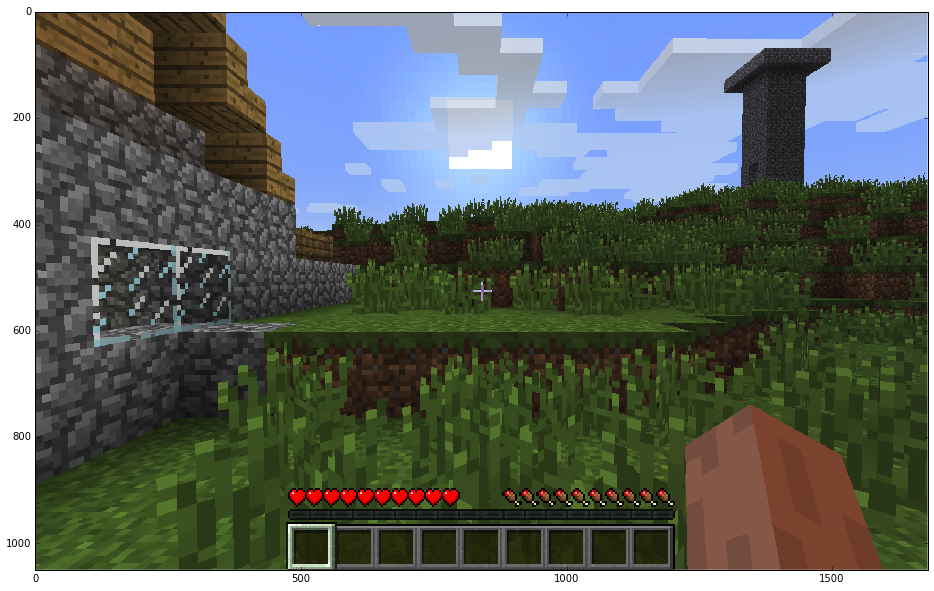

In [5]:
plt.figure(figsize = (16, 10))
plt.imshow(image, interpolation='none');

### Load all of the image files from the screen captures generated in different world regions

#### List of classes that will be added to the dataset

In [56]:
class_names = ['farm', 'forest', 'home']

In [57]:
import glob
filenames = dict()
for class_name in class_names:
    filenames[class_name] = glob.glob('/Users/cosmo/Documents/workspace/screenshot/{0}/*.png'.format(class_name))

#### Shuffle the order of the images to remove the temporal correlation

In [58]:
np.random.shuffle(farm_files)
np.random.shuffle(forest_files)
np.random.shuffle(home_files)

#### Also create a small test list for development purposes

In [59]:
test_files = farm_files[:20]

#### Downsampling the images is possible:

In [60]:
h_scale = 10
v_scale = 10
plt.figure(figsize = (8, 5));
# plt.imshow(imresize(image, (128, 128)), interpolation='none');

If we don't downsample, we have $1680*1050=1764000$ pixels per image. If we downsample by a factor of 5, then we have $336*210=70560$ pixels per image. If we downsample to (128, 128) images then we have 16384 pixels per image.

## Create the HDF5 dataset

In [205]:
import h5py
from fuel.datasets.hdf5 import H5PYDataset

In [206]:
filename = 'minecraft0.1.downsampled.hdf5'
f = h5py.File(filename, mode='w')

#### Load a single image to get the parameters

In [207]:
# We can optionally downsample the images before adding them to the dataset
downsample = True

# How many images to add to the dataset in each batch before flushing to disk
batch_size = 100

# Define how much of the dataset to use for training versus testing
training_percent = 0.70

# Assumption: all images have the same size and each class contains the same number of images
test_image = ndimage.imread(filenames['farm'][0])
h, w, num_channels = test_image.shape

# if downsampled, enter the new width and height here
h = 128
w = 128

num_images = 0
for cl in filenames:
    num_images += len(filenames[cl])
    
images_per_class = len(filenames['farm'])

In [208]:
h, w, num_channels, num_images, images_per_class, batch_size, downsample

(128, 128, 3, 3600, 1200, 100, True)

#### Create the features and targets datasets

##### Create the features dataset

In [209]:
features = f.create_dataset('features', (num_images, h, w, num_channels), dtype='uint8')

In [210]:
features.shape

(3600, 128, 128, 3)

##### Create the targets dataset

In [211]:
targets = f.create_dataset('targets', (num_images, 2), dtype='uint8')

In [212]:
targets.shape

(3600, 2)

In [243]:
# todo: add labels to the datasets

#### Load the images into the dataset

Since we have a large number of images to add to the dataset, we divide the work into batches, and flush to disk every 100 images.

In [213]:
# If downsample is True, then we need to define the image size here
image_size = (h, w)

# Calculate how many batches will be needed per class
batches_per_class = int(images_per_class / batch_size)

# For each image class
# for class_idx in range(len(class_names)):
for class_idx, class_name in enumerate(class_names):
    print('Processing class: {0}'.format(class_name))

    # Split this class into batches_per_class batches
    for batch in range(batches_per_class):
        # Compute the offset based on what batch number we are on in order
        # to add the offset to the image index in the vector of images
        offset = batch * batch_size
        for i in range(batch_size):
            image = ndimage.imread(filenames[class_name][offset + i])
            image_index = class_idx * images_per_class + offset + i
            
            if downsample:
                features[image_index] = imresize(image, image_size)
            else:
                # This is where the image gets added to the HDF5 dataset:
                features[image_index] = image
            
            # Add the class label
            targets[image_index] = class_idx
                
        # Write the dataset that has been constructed so far to disk
        f.flush()
        print('Batch #{0}/{1} done.'.format(batch + 1, batches_per_class))

Processing class: farm
Batch #1/12 done.
Batch #2/12 done.
Batch #3/12 done.
Batch #4/12 done.
Batch #5/12 done.
Batch #6/12 done.
Batch #7/12 done.
Batch #8/12 done.
Batch #9/12 done.
Batch #10/12 done.
Batch #11/12 done.
Batch #12/12 done.
Processing class: forest
Batch #1/12 done.
Batch #2/12 done.
Batch #3/12 done.
Batch #4/12 done.
Batch #5/12 done.
Batch #6/12 done.
Batch #7/12 done.
Batch #8/12 done.
Batch #9/12 done.
Batch #10/12 done.
Batch #11/12 done.
Batch #12/12 done.
Processing class: home
Batch #1/12 done.
Batch #2/12 done.
Batch #3/12 done.
Batch #4/12 done.
Batch #5/12 done.
Batch #6/12 done.
Batch #7/12 done.
Batch #8/12 done.
Batch #9/12 done.
Batch #10/12 done.
Batch #11/12 done.
Batch #12/12 done.


#### Split into train and test

In [214]:
# make a list of all the indices, and reshape it into 3 classes
indices = np.arange(num_images).reshape((len(class_names), images_per_class))

In [215]:
# shuffle within each class
np.random.shuffle(indices.T)

In [216]:
# compute the number of training examples per class
num_training = int(training_percent * images_per_class)
num_training

840

In [217]:
# choose a subset of the indices in each class for training
f['train_indices'] = np.concatenate(indices[:, :num_training])

In [218]:
# choose a subset of the indices in each class for testing
f['test_indices'] = np.concatenate(indices[:, num_training:])

In [219]:
train_ref = f['train_indices'].ref

In [220]:
test_ref = f['test_indices'].ref

In [221]:
split_dict = {
    'train': {'features': (-1, -1, train_ref),
              'targets': (-1, -1, train_ref)},
    'test':  {'features': (-1, -1, test_ref),
              'targets': (-1, -1, test_ref)},
}

f.attrs['split'] = H5PYDataset.create_split_array(split_dict)

In [222]:
f.flush()
f.close()

### Access the HDF5 dataset we created

In [223]:
from fuel.datasets.hdf5 import H5PYDataset

In [233]:
filename = 'minecraft0.1.downsampled.hdf5'

In [247]:
size_training_set = H5PYDataset(filename, which_sets=('train',)).num_examples

Split the training set into train_set and valid_set:

In [252]:
num_training = round(2520*.8)
num_validation = size_training_set - num_training
num_training, num_validation

(2016, 504)

In [254]:
train_set = H5PYDataset(filename, which_sets=('train',), subset=slice(0, num_training))

In [255]:
valid_set = H5PYDataset(filename, which_sets=('train',), subset=slice(num_training, size_training_set))

In [258]:
test_set = H5PYDataset(filename, which_sets=('test',))

In [257]:
train_set.num_examples, valid_set.num_examples, test_set.num_examples

(2016, 504, 1080)

We can view the available data sources:

In [238]:
print(train_set.provides_sources)

('features', 'targets')


In [244]:
print(train_set.axis_labels['features'])
# todo: add labels to the dataset (see above)

('', '', '', '')


In [259]:
handle = train_set.open()

#### Load a small slice from each subset of the data and look at the resulting images

In [284]:
data = train_set.get_data(handle, slice(0, train_set.num_examples))

In [286]:
data[1]  # class labels

array([[0, 0],
       [0, 0],
       [0, 0],
       ..., 
       [2, 2],
       [2, 2],
       [2, 2]], dtype=uint8)

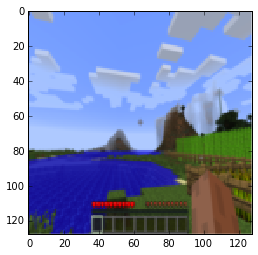

In [287]:
plt.imshow(data[0][0], interpolation='none');

#### Visualize some random images from the training set

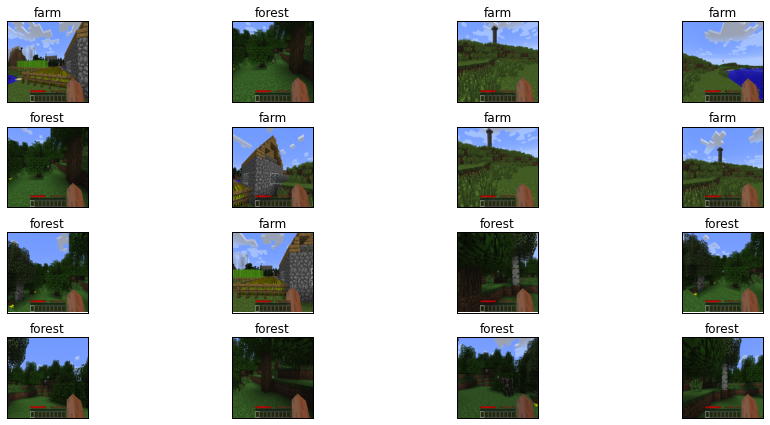

In [290]:
fig = plt.figure(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k');
class_names = ['farm', 'forest', 'home']
for i in range(4):
    for j in range(4):
        idx = np.random.randint(train_set.num_examples)
        ax = fig.add_subplot(4,4,i*4+j+1);
        ax.imshow(data[0][idx]);
        ax.set_title(class_names[data[1][idx][0]]);
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
fig.tight_layout();

In [22]:
dataset.close(handle)